# **`Quick Draw!` Classification with ResNet**

> modified from [rasbt/deeplearning-models/pytorch_ipynb](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet34-quickdraw.ipynb)

## **0. Goal**

1. ResNet-34 모델의 구조를 밑바닥부터 구현해보기

2. 기학습된(pre-trained) ResNet 모델을 `torchvision`에서 불러와, 마지막 레이어만 학습 데이터에 대해 fine-tuning 하기

## **1. Settings**

In [1]:
# Install QuickDraw Dataset
!pip3 install quickdraw

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import logging

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Import package for data loading and augmentation
from quickdraw import QuickDrawData, QuickDrawDataGroup
from torchvision import transforms


# A magic command to display the plots in the notebook
%matplotlib inline
# A magic command for high resolution plots
%config InlineBackend.figure_format='retina'

In [3]:
# PyTorch 버전 확인
print(f'PyTorch version : {torch.__version__}')

# GPU 사용 가능 여부 확인
print(f'CUDA 사용 가능 : {torch.cuda.is_available()}')

# MacOS에서 MPS(Multi-Process Service)를 사용할 수 있는지 확인
print(f'MPS 사용 가능 : {torch.backends.mps.is_available()}')


# 디바이스 지정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'학습 디바이스 : {device}')

PyTorch version : 2.1.0
CUDA 사용 가능 : False
MPS 사용 가능 : True
학습 디바이스 : mps


In [4]:
# 재현성을 위한 random seed 설정
# https://pytorch.org/docs/stable/notes/randomness.html

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# 네트워크 구조는 ResNet-34를 그대로 따를 것이므로 그에 대한 설정은 생략
# 학습에 필요한 하이퍼파라미터
LEARNING_RATE = 1e-4  # 0.0001
EPOCHS = 30
PRINT_EPOCH = 1
BATCH_SIZE = 128

## **2. Prepare Quickdraw dataset**

- [Quickdraw dataset homepage](https://quickdraw.withgoogle.com/data)

- 실습을 간소화하기 위해 아래와 같이 설정하도록 하겠습니다.
    - 10개의 클래스만 사용
    - 각 클래스당 최대 500개의 이미지만 사용
    - 이미지 크기를 150px * 150px로 조정

In [6]:
# 사용할 클래스 라벨과 이미지 개수 설정
class_list = ['apple', 'banana', 'cat', 'dog', 'elephant', 'fish', 
              'giraffe', 'hedgehog', 'ice cream', 'jail']

class_dict = {item: index for index, item in enumerate(class_list)}
num_img_per_class = 500

print('class dictionary: {}'.format(class_dict))
print('number of images per class: {}'.format(num_img_per_class))

class dictionary: {'apple': 0, 'banana': 1, 'cat': 2, 'dog': 3, 'elephant': 4, 'fish': 5, 'giraffe': 6, 'hedgehog': 7, 'ice cream': 8, 'jail': 9}
number of images per class: 500


In [7]:
# QuickDrawData 객체를 통해 클래스별로 이미지를 다운로드 및 로딩
qd = QuickDrawData(max_drawings=num_img_per_class)
qd.load_drawings(class_list)

loading apple drawings
load complete
loading banana drawings
load complete
loading cat drawings
load complete
loading dog drawings
load complete
loading elephant drawings
load complete
loading fish drawings
load complete
loading giraffe drawings
load complete
loading hedgehog drawings
load complete
loading ice cream drawings
load complete
loading jail drawings
load complete


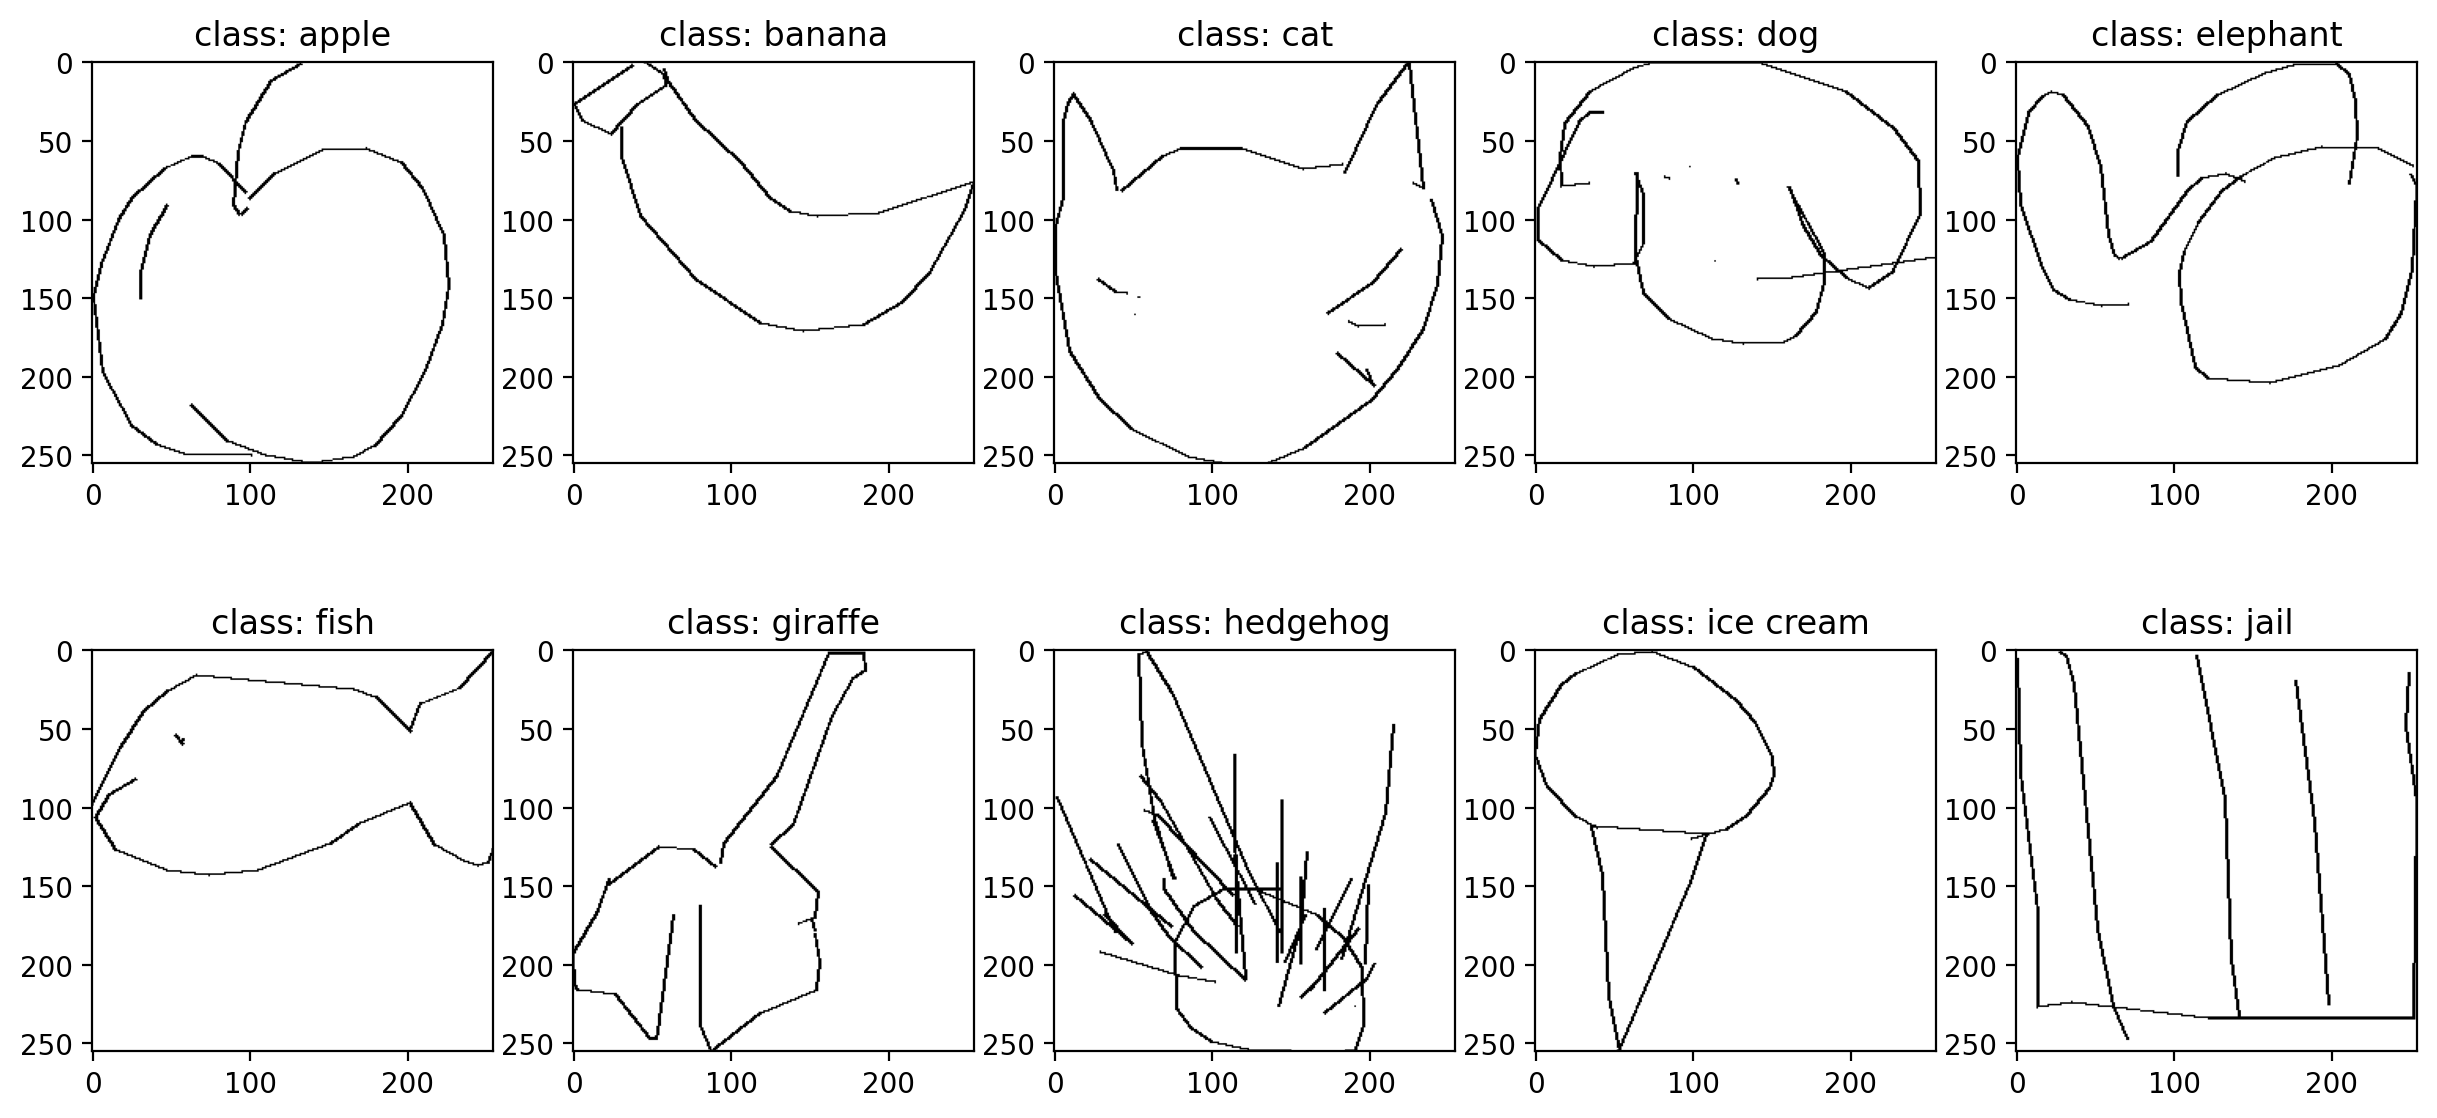

In [8]:
# 각 클래스 라벨별로 이미지의 샘플을 하나씩 시각화
plt.figure(figsize=(15,7))
for i, class_name in enumerate(class_list):
    # 5행 2열의 서브플롯에서 i+1번째에 이미지 그리기
    plt.subplot(2, 5, i+1)
    # qd.get_drawing(class_name)을 통해 해당 클래스의 이미지를 하나씩 불러옴
    img = np.asarray(qd.get_drawing(class_name).image, dtype=np.uint8)
    plt.imshow(np.array(img))
    plt.title('class: {}'.format(class_name))
plt.show()

In [9]:
# 이미지 및 라벨을 저장할 리스트 생성
train_data = list()
val_data = list()
train_label = list()
val_label = list()

# 클래스별로 이미지를 불러와서 리스트에 저장
# QuickDrawDataGroup 클래스를 사용하면 클래스별로 데이터를 불러올 수 있음
for class_name in class_list:
    qdgroup = QuickDrawDataGroup(class_name, max_drawings=num_img_per_class)
    for i, img in enumerate(qdgroup.drawings):
        if i < int(0.9 * num_img_per_class):
            train_data.append(np.asarray(img.get_image()))
            train_label.append(class_dict[class_name])
        else:
            val_data.append(np.asarray(img.get_image()))
            val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading banana drawings
load complete
loading cat drawings
load complete
loading dog drawings
load complete
loading elephant drawings
load complete
loading fish drawings
load complete
loading giraffe drawings
load complete
loading hedgehog drawings
load complete
loading ice cream drawings
load complete
loading jail drawings
load complete


In [10]:
# 데이터를 전처리하는 함수 정의 (텐서 변환 -> 150*150 -> 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 학습 데이터의 경우 데이터 증강을 위해 RandomHorizontalFlip 적용
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
# 커스텀 데이터셋 클래스 정의
class QuickDrawDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(np.array(img))
        return img, label

In [12]:
# 학습 및 검증 데이터셋 생성
qd_train_dataset = QuickDrawDataset(train_data, 
                                    train_label, 
                                    train_transform)
qd_val_dataset = QuickDrawDataset(val_data, 
                                  val_label, 
                                  transform)

In [13]:
# 학습 및 검증 데이터 로더 생성 (torch.utils.data.DataLoader 이용)
qd_train_dataloader = DataLoader(qd_train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

qd_val_dataloader = DataLoader(qd_val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

## **3. Create ResNet-34 from Scratch**

- [ResNet 논문](https://arxiv.org/pdf/1512.03385.pdf)에 제안된 모델의 구조

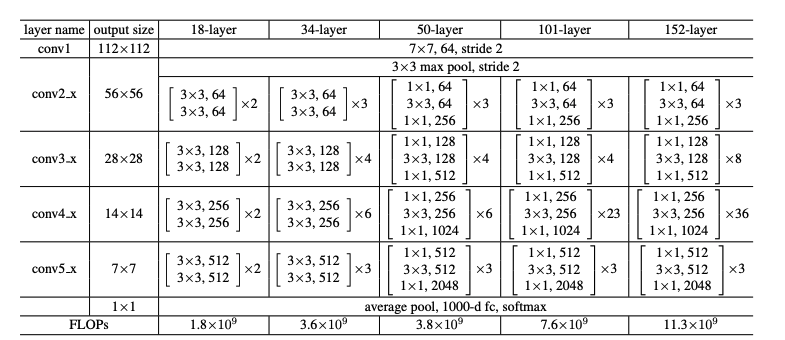

- input: (batch_size, 3, 150, 150)    
- output: (batch_size, 10)

- 위의 모델 구조를 참고하여, 각각의 레이어를 `ConvBlock`과 `ResBlock`으로 구현하자.
    - `ConvBlock` : conv + batchnorm + activation func(ReLU)
    - `ResBlock` : `ConvBlock` + `ConvBlock` + residual connection

   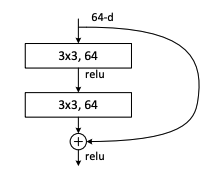

### **3.1. ConvBlock**
conv + batchnorm + activation func(ReLU)

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels, out_channels, 
                 kernel_size=3, stride=1, padding=1, 
                 bias=True, add_norm="bnorm", add_relu=True):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                            kernel_size=kernel_size, stride=stride, padding=padding,
                            bias=bias)]

        if add_norm == "bnorm":
            layers += [nn.BatchNorm2d(num_features=out_channels)]

        if add_relu:
            layers += [nn.ReLU()]

        self.cbr = nn.Sequential( * layers)

    def forward(self, x):
        return self.cbr(x)

In [15]:
# [3 x 3, 64] 에 대한 ConvBlock 테스트해보기

x = torch.randn(1, 3, 150, 150)
convblock = ConvBlock(in_channels=3, out_channels=64)

print(f'입력 텐서 크기 : {x.shape}')
print(f'출력 텐서 크기 : {convblock(x).shape}')

입력 텐서 크기 : torch.Size([1, 3, 150, 150])
출력 텐서 크기 : torch.Size([1, 64, 150, 150])


### **3.2. ResBlock**
ConvBlock + ConvBlock + residual connection

In [16]:
class ResBlock(nn.Module):
    def __init__(self, 
                 in_channels, out_channels, 
                 kernel_size=3, stride=1, padding=1, 
                 bias=True, add_norm="bnorm"):
        super().__init__()

        layers = []

        # 1st conv
        layers += [ConvBlock(in_channels=in_channels, out_channels=out_channels,
                            kernel_size=kernel_size, stride=stride, padding=padding,
                            bias=bias, add_norm=add_norm, add_relu=True)]

        # 2nd conv
        layers += [ConvBlock(in_channels=out_channels, out_channels=out_channels,
                            kernel_size=kernel_size, stride=stride, padding=padding,
                            bias=bias, add_norm=add_norm, add_relu=False)]

        self.resblk = nn.Sequential( * layers)
        self.short_cut = nn.Conv2d(in_channels, out_channels, (1,1), stride=1)
        self.relu = nn.ReLU()

    def forward(self, x, short_cut=False):
        if short_cut:
            x = self.short_cut(x) + self.resblk(x)
        else:
            x = x + self.resblk(x)
        
        return self.relu(x)

In [17]:
# [3 x 3, 64] * 2 에 대한 ResBlock 테스트해보기

x = torch.randn(1, 3, 150, 150)
resblock = ResBlock(in_channels=3, out_channels=64)

print(f'입력 텐서 크기 : {x.shape}')
print(f'출력 텐서 크기 : {resblock(x, short_cut=True).shape}')

입력 텐서 크기 : torch.Size([1, 3, 150, 150])
출력 텐서 크기 : torch.Size([1, 64, 150, 150])


### **3.3. ResNet34**

In [18]:
class ResNet34(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 n_kernel=64, norm="bnorm", nblk=[3,4,6,3]):
        super(ResNet34, self).__init__()

        self.enc = ConvBlock(in_channels, n_kernel, 
                            kernel_size=7, stride=2, padding=1, 
                            bias=True, add_norm=norm, add_relu=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        res_1 = ResBlock(n_kernel, n_kernel, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_1 = nn.Sequential( * [res_1 for _ in range(nblk[0])])

        res_2 = ResBlock(n_kernel * 2, n_kernel * 2, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_2_up = ResBlock(n_kernel, n_kernel * 2, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_2 = nn.Sequential( * [res_2 for _ in range(nblk[1]-1)])

        res_3 = ResBlock(n_kernel * 2 * 2, n_kernel * 2 * 2, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_3_up = ResBlock(n_kernel * 2, n_kernel * 2 * 2, 
                                kernel_size=3, stride=1, padding=1, 
                                bias=True, add_norm=norm)
        self.res_3 = nn.Sequential( * [res_3 for _ in range(nblk[2]-1)])

        res_4 = ResBlock(n_kernel * 2 * 2 * 2, n_kernel * 2 * 2 * 2, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_4_up = ResBlock(n_kernel * 2 * 2, n_kernel * 2 * 2 * 2, 
                        kernel_size=3, stride=1, padding=1, 
                        bias=True, add_norm=norm)
        self.res_4 = nn.Sequential( * [res_4 for _ in range(nblk[3]-1)])

        self.avg_pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(n_kernel * 2 * 2 * 2, 10)

        # Initialize the weights of the model
        self.init_weights()
    
    ''' Initialize the weights of the model '''
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv2d
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.enc(x)
        x = self.max_pool(x)
        x = self.res_1(x)
        x = self.max_pool(x)

        x = self.res_2_up(x, short_cut=True)
        x = self.res_2(x)
        x = self.max_pool(x)

        x = self.res_3_up(x, short_cut=True)
        x = self.res_3(x)
        x = self.max_pool(x)

        x = self.res_4_up(x, short_cut=True)
        x = self.res_4(x)
        
        x = self.avg_pooling(x)
        x = x.view(x.shape[0], -1)
        out = self.fc(x)
        return out

In [19]:
# ResNet34 모델 테스트

x = torch.randn(7, 3, 150, 150)
resnet34 = ResNet34(in_channels=3, out_channels=10)

print(f'입력 텐서 크기 : {x.shape}')
print(f'출력 텐서 크기 : {resnet34(x).shape}')

입력 텐서 크기 : torch.Size([7, 3, 150, 150])
출력 텐서 크기 : torch.Size([7, 10])


## **4. Create Evaluation Function**

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
def func_eval(model, criterion, data_iter, device):
    ''' Evaluate the model with the given data set 
        args:
            model: model
            data_iter: data iterator
            device: cpu or gpu
        returns:
            val_acc: validation accuracy
    '''

    # no need to compute the gradients (such a waste of time!)
    with torch.no_grad():
        # initialize the average meter
        valid_loss, valid_acc = AverageMeter(), AverageMeter() 
        # set the model in evaluation mode (affects BatchNorm and dropout)
        model.eval()

        # for each mini-batch, compute the accuracy
        for img, label in data_iter:
            # move the mini-batch to the given device (cpu or gpu)
            img, label = img.to(device), label.to(device)

            # compute the model output
            model_pred = model(img)

            # compute the loss
            loss = criterion(model_pred, label)

            # compute the accuracy
            pred_label = torch.argmax(model_pred, 1)
            acc = (pred_label == label).sum().item() / len(img)

            # update the loss and accuracy
            valid_loss.update(loss.item(), len(img))
            valid_acc.update(acc, len(img))
        
        # Compute the average loss and accuracy
        valid_loss = valid_loss.avg
        valid_acc = valid_acc.avg

        # back to train mode since we are done with evaluation
        model.train()
    
    # return the accuracy
    return valid_loss, valid_acc

print ("Done")

Done


## **5. Training ResNet-34 from Scratch**

In [22]:
# Build user-defined ResNet34 model
model_scratch = ResNet34(3, 10).to(device)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

In [23]:
# Main
log_dir ='./log'
log_fname = 'log_0.txt'
os.makedirs(log_dir, exist_ok=True)
if os.path.isfile(os.path.join(log_dir, log_fname)):
    os.remove(os.path.join(log_dir, log_fname))

logger = logging.getLogger('train')
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(os.path.join(log_dir, log_fname))
logger.addHandler(file_handler)
stream_handler = logging.StreamHandler()
logger.addHandler(stream_handler)

# Training
model_scratch.train()
print('Start training..')
for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = AverageMeter(), AverageMeter()
    
    for img, label in tqdm(qd_train_dataloader):
        # 미니배치를 device에 할당
        img = img.to(device)
        label = label.to(device)

        # 순전파
        pred_logit = model_scratch(img)

        # 손실함수 계산
        loss = criterion(pred_logit, label)
                
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # 역전파
        loss.backward()
        optimizer.step()

        # 정확도 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        # loss와 accuracy 업데이트
        train_loss.update(loss.item(), len(img))
        train_acc.update(acc, len(img))

    # loss와 accuracy의 평균을 계산
    train_loss = train_loss.avg
    train_acc = train_acc.avg

    # 매 PRINT_EPOCH마다 loss와 accuracy 출력
    if ((epoch % PRINT_EPOCH) == 0) or (epoch == (EPOCHS-1)):
        valid_loss, valid_acc = func_eval(model_scratch, criterion, qd_val_dataloader, device)

        logger.info(f"Epoch {epoch:02d}/{EPOCHS:02d} | "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc*100:.2f}% | "
              f"Valid Loss {valid_loss:.4f} | Valid Acc {valid_acc*100:.2f}%")

print(f'Finished Training')

Start training..


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/30 | Train Loss 3.1727 | Train Acc 53.20% | Valid Loss 1.0783 | Valid Acc 67.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/30 | Train Loss 0.6256 | Train Acc 80.31% | Valid Loss 0.9033 | Valid Acc 71.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/30 | Train Loss 0.4489 | Train Acc 85.71% | Valid Loss 0.8871 | Valid Acc 71.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/30 | Train Loss 0.3869 | Train Acc 87.89% | Valid Loss 1.0551 | Valid Acc 69.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/30 | Train Loss 0.3035 | Train Acc 90.89% | Valid Loss 0.6763 | Valid Acc 78.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/30 | Train Loss 0.2356 | Train Acc 92.82% | Valid Loss 0.7654 | Valid Acc 77.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/30 | Train Loss 0.1631 | Train Acc 95.60% | Valid Loss 0.7955 | Valid Acc 78.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/30 | Train Loss 0.1257 | Train Acc 96.60% | Valid Loss 1.1057 | Valid Acc 73.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/30 | Train Loss 0.1182 | Train Acc 96.78% | Valid Loss 1.4034 | Valid Acc 75.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss 0.0811 | Train Acc 98.13% | Valid Loss 2.1138 | Valid Acc 71.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss 0.0634 | Train Acc 98.47% | Valid Loss 0.8333 | Valid Acc 76.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss 0.0419 | Train Acc 99.13% | Valid Loss 1.2768 | Valid Acc 73.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss 0.0570 | Train Acc 98.51% | Valid Loss 1.4946 | Valid Acc 74.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss 0.0538 | Train Acc 98.47% | Valid Loss 0.7598 | Valid Acc 81.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss 0.0323 | Train Acc 99.07% | Valid Loss 0.9426 | Valid Acc 77.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss 0.0341 | Train Acc 99.24% | Valid Loss 2.0785 | Valid Acc 72.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss 0.0641 | Train Acc 98.38% | Valid Loss 0.9830 | Valid Acc 76.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss 0.0269 | Train Acc 99.11% | Valid Loss 1.2252 | Valid Acc 78.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss 0.0154 | Train Acc 99.60% | Valid Loss 1.7086 | Valid Acc 73.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss 0.0087 | Train Acc 99.76% | Valid Loss 1.0432 | Valid Acc 79.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss 0.0078 | Train Acc 99.91% | Valid Loss 1.0913 | Valid Acc 80.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss 0.0041 | Train Acc 99.98% | Valid Loss 0.8505 | Valid Acc 80.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss 0.0034 | Train Acc 99.98% | Valid Loss 0.8769 | Valid Acc 81.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss 0.0016 | Train Acc 100.00% | Valid Loss 0.8961 | Valid Acc 81.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss 0.0015 | Train Acc 99.98% | Valid Loss 0.8883 | Valid Acc 82.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss 0.0016 | Train Acc 100.00% | Valid Loss 0.9007 | Valid Acc 80.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss 0.0010 | Train Acc 100.00% | Valid Loss 0.8885 | Valid Acc 81.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss 0.0030 | Train Acc 99.96% | Valid Loss 0.9484 | Valid Acc 81.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss 0.0010 | Train Acc 100.00% | Valid Loss 0.9382 | Valid Acc 81.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss 0.0008 | Train Acc 100.00% | Valid Loss 0.9765 | Valid Acc 80.60%


Finished Training


## **6. Fine-tuning ResNet-34 with pretrained feature extractor**

- 사전학습된 ResNet-34을 `torchvision.models`에서 불러와서 사용합니다.

- 다양한 방식으로 파인튜닝(fine tuning)하는 방법이 존재하는데,
    - 저희는 **feature extractor를 고정(freeze;fix)시키고, <br>classifier 역할을 할 마지막 레이어만 학습**시키는 방법을 사용해보겠습니다.

In [24]:
from torchvision.models import resnet34

# Build ResNet34 model using torchvision
model_finetune = resnet34(weights='DEFAULT')

# Freeze the feature extracting convolution layers
for param in model_finetune.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer
# parameters of newly constructed modules have requires_grad=True by default
model_finetune.fc = nn.Linear(512, 10, bias=True)

# Move to the given device (cpu or gpu)
model_finetune = model_finetune.to(device)

In [25]:
# Loss function and Optimizer
criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_finetune.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

In [26]:
# Main
log_dir ='./log_finetuning'
log_fname = 'log_0.txt'
os.makedirs(log_dir, exist_ok=True)
if os.path.isfile(os.path.join(log_dir, log_fname)):
    os.remove(os.path.join(log_dir, log_fname))

logger_ft = logging.getLogger('finetuning')
logger_ft.setLevel(logging.INFO)
file_handler = logging.FileHandler(os.path.join(log_dir, log_fname))
logger_ft.addHandler(file_handler)
stream_handler = logging.StreamHandler()
logger_ft.addHandler(stream_handler)

# Training
model_finetune.train()
print('Start training..')

for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = AverageMeter(), AverageMeter()
    
    for img, label in tqdm(qd_train_dataloader):
        # 미니배치를 device에 할당
        img = img.to(device)
        label = label.to(device)

        # 순전파
        pred_logit = model_finetune(img)

        # 손실함수 계산
        loss = criterion_ft(pred_logit, label)
                
        # 그래디언트 초기화
        optimizer_ft.zero_grad()
        
        # 역전파
        loss.backward()
        optimizer_ft.step()

        # 정확도 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        # loss와 accuracy 업데이트
        train_loss.update(loss.item(), len(img))
        train_acc.update(acc, len(img))

    # loss와 accuracy의 평균을 계산
    train_loss = train_loss.avg
    train_acc = train_acc.avg

    # 매 PRINT_EPOCH마다 loss와 accuracy 출력
    if ((epoch % PRINT_EPOCH) == 0) or (epoch == (EPOCHS-1)):
        valid_loss, valid_acc = func_eval(model_finetune, criterion_ft, qd_val_dataloader, device)

        logger_ft.info(f"Epoch {epoch:02d}/{EPOCHS:02d} | "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc*100:.2f}% | "
              f"Valid Loss {valid_loss:.4f} | Valid Acc {valid_acc*100:.2f}%")
        
print(f'Finished Training')

Start training..


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/30 | Train Loss 2.2331 | Train Acc 19.76% | Valid Loss 2.1262 | Valid Acc 26.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/30 | Train Loss 1.9743 | Train Acc 35.09% | Valid Loss 1.8560 | Valid Acc 44.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/30 | Train Loss 1.7695 | Train Acc 50.18% | Valid Loss 1.6519 | Valid Acc 58.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/30 | Train Loss 1.5907 | Train Acc 60.13% | Valid Loss 1.5027 | Valid Acc 64.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/30 | Train Loss 1.4440 | Train Acc 66.16% | Valid Loss 1.3631 | Valid Acc 68.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/30 | Train Loss 1.3214 | Train Acc 70.09% | Valid Loss 1.2615 | Valid Acc 71.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/30 | Train Loss 1.2237 | Train Acc 72.18% | Valid Loss 1.1679 | Valid Acc 74.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/30 | Train Loss 1.1304 | Train Acc 75.22% | Valid Loss 1.0958 | Valid Acc 76.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/30 | Train Loss 1.0605 | Train Acc 76.20% | Valid Loss 1.0296 | Valid Acc 77.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss 1.0045 | Train Acc 77.27% | Valid Loss 0.9728 | Valid Acc 78.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss 0.9395 | Train Acc 79.07% | Valid Loss 0.9270 | Valid Acc 78.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss 0.9025 | Train Acc 79.00% | Valid Loss 0.8866 | Valid Acc 79.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss 0.8599 | Train Acc 79.73% | Valid Loss 0.8583 | Valid Acc 80.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss 0.8287 | Train Acc 79.64% | Valid Loss 0.8245 | Valid Acc 80.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss 0.7990 | Train Acc 81.04% | Valid Loss 0.8023 | Valid Acc 80.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss 0.7715 | Train Acc 81.44% | Valid Loss 0.7783 | Valid Acc 81.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss 0.7437 | Train Acc 81.96% | Valid Loss 0.7530 | Valid Acc 80.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss 0.7271 | Train Acc 82.13% | Valid Loss 0.7339 | Valid Acc 82.00%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss 0.7030 | Train Acc 82.93% | Valid Loss 0.7137 | Valid Acc 82.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss 0.6910 | Train Acc 82.51% | Valid Loss 0.7004 | Valid Acc 81.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss 0.6694 | Train Acc 83.42% | Valid Loss 0.6926 | Valid Acc 82.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss 0.6574 | Train Acc 83.51% | Valid Loss 0.6735 | Valid Acc 82.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss 0.6416 | Train Acc 83.71% | Valid Loss 0.6578 | Valid Acc 81.80%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss 0.6272 | Train Acc 83.91% | Valid Loss 0.6465 | Valid Acc 82.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss 0.6159 | Train Acc 84.33% | Valid Loss 0.6326 | Valid Acc 83.40%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss 0.6033 | Train Acc 84.76% | Valid Loss 0.6289 | Valid Acc 83.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss 0.5993 | Train Acc 84.80% | Valid Loss 0.6175 | Valid Acc 84.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss 0.5796 | Train Acc 85.38% | Valid Loss 0.6084 | Valid Acc 83.60%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss 0.5750 | Train Acc 84.87% | Valid Loss 0.6040 | Valid Acc 85.20%


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss 0.5732 | Train Acc 84.36% | Valid Loss 0.5916 | Valid Acc 84.20%


Finished Training


## **7. Visualize the Results**

### **7.1. Visualize the training progess**

In [27]:
def str2num(s):
    ''' Convert string to number (if possible) '''
    s = s.split()[-1].replace('%','e-2')
    return float(s)

def parse_log(log_file):
    ''' Parse the log file and return the loss and accuracy '''
    df = pd.read_csv(log_file, sep='|', header=None, engine='python').iloc[:, 1:]
    df = df.map(str2num)
    df.columns = ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']

    return df

In [28]:
# Load log file
scratch_train_log = parse_log('./log/log_0.txt')
finetune_train_log = parse_log('./log_finetuning/log_0.txt')

scratch_train_log.head()

,train_loss,train_acc,valid_loss,valid_acc
0,3.1727,0.5320,1.0783,0.672
1,0.6256,0.8031,0.9033,0.712
2,0.4489,0.8571,0.8871,0.718
3,0.3869,0.8789,1.0551,0.696
4,0.3035,0.9089,0.6763,0.786


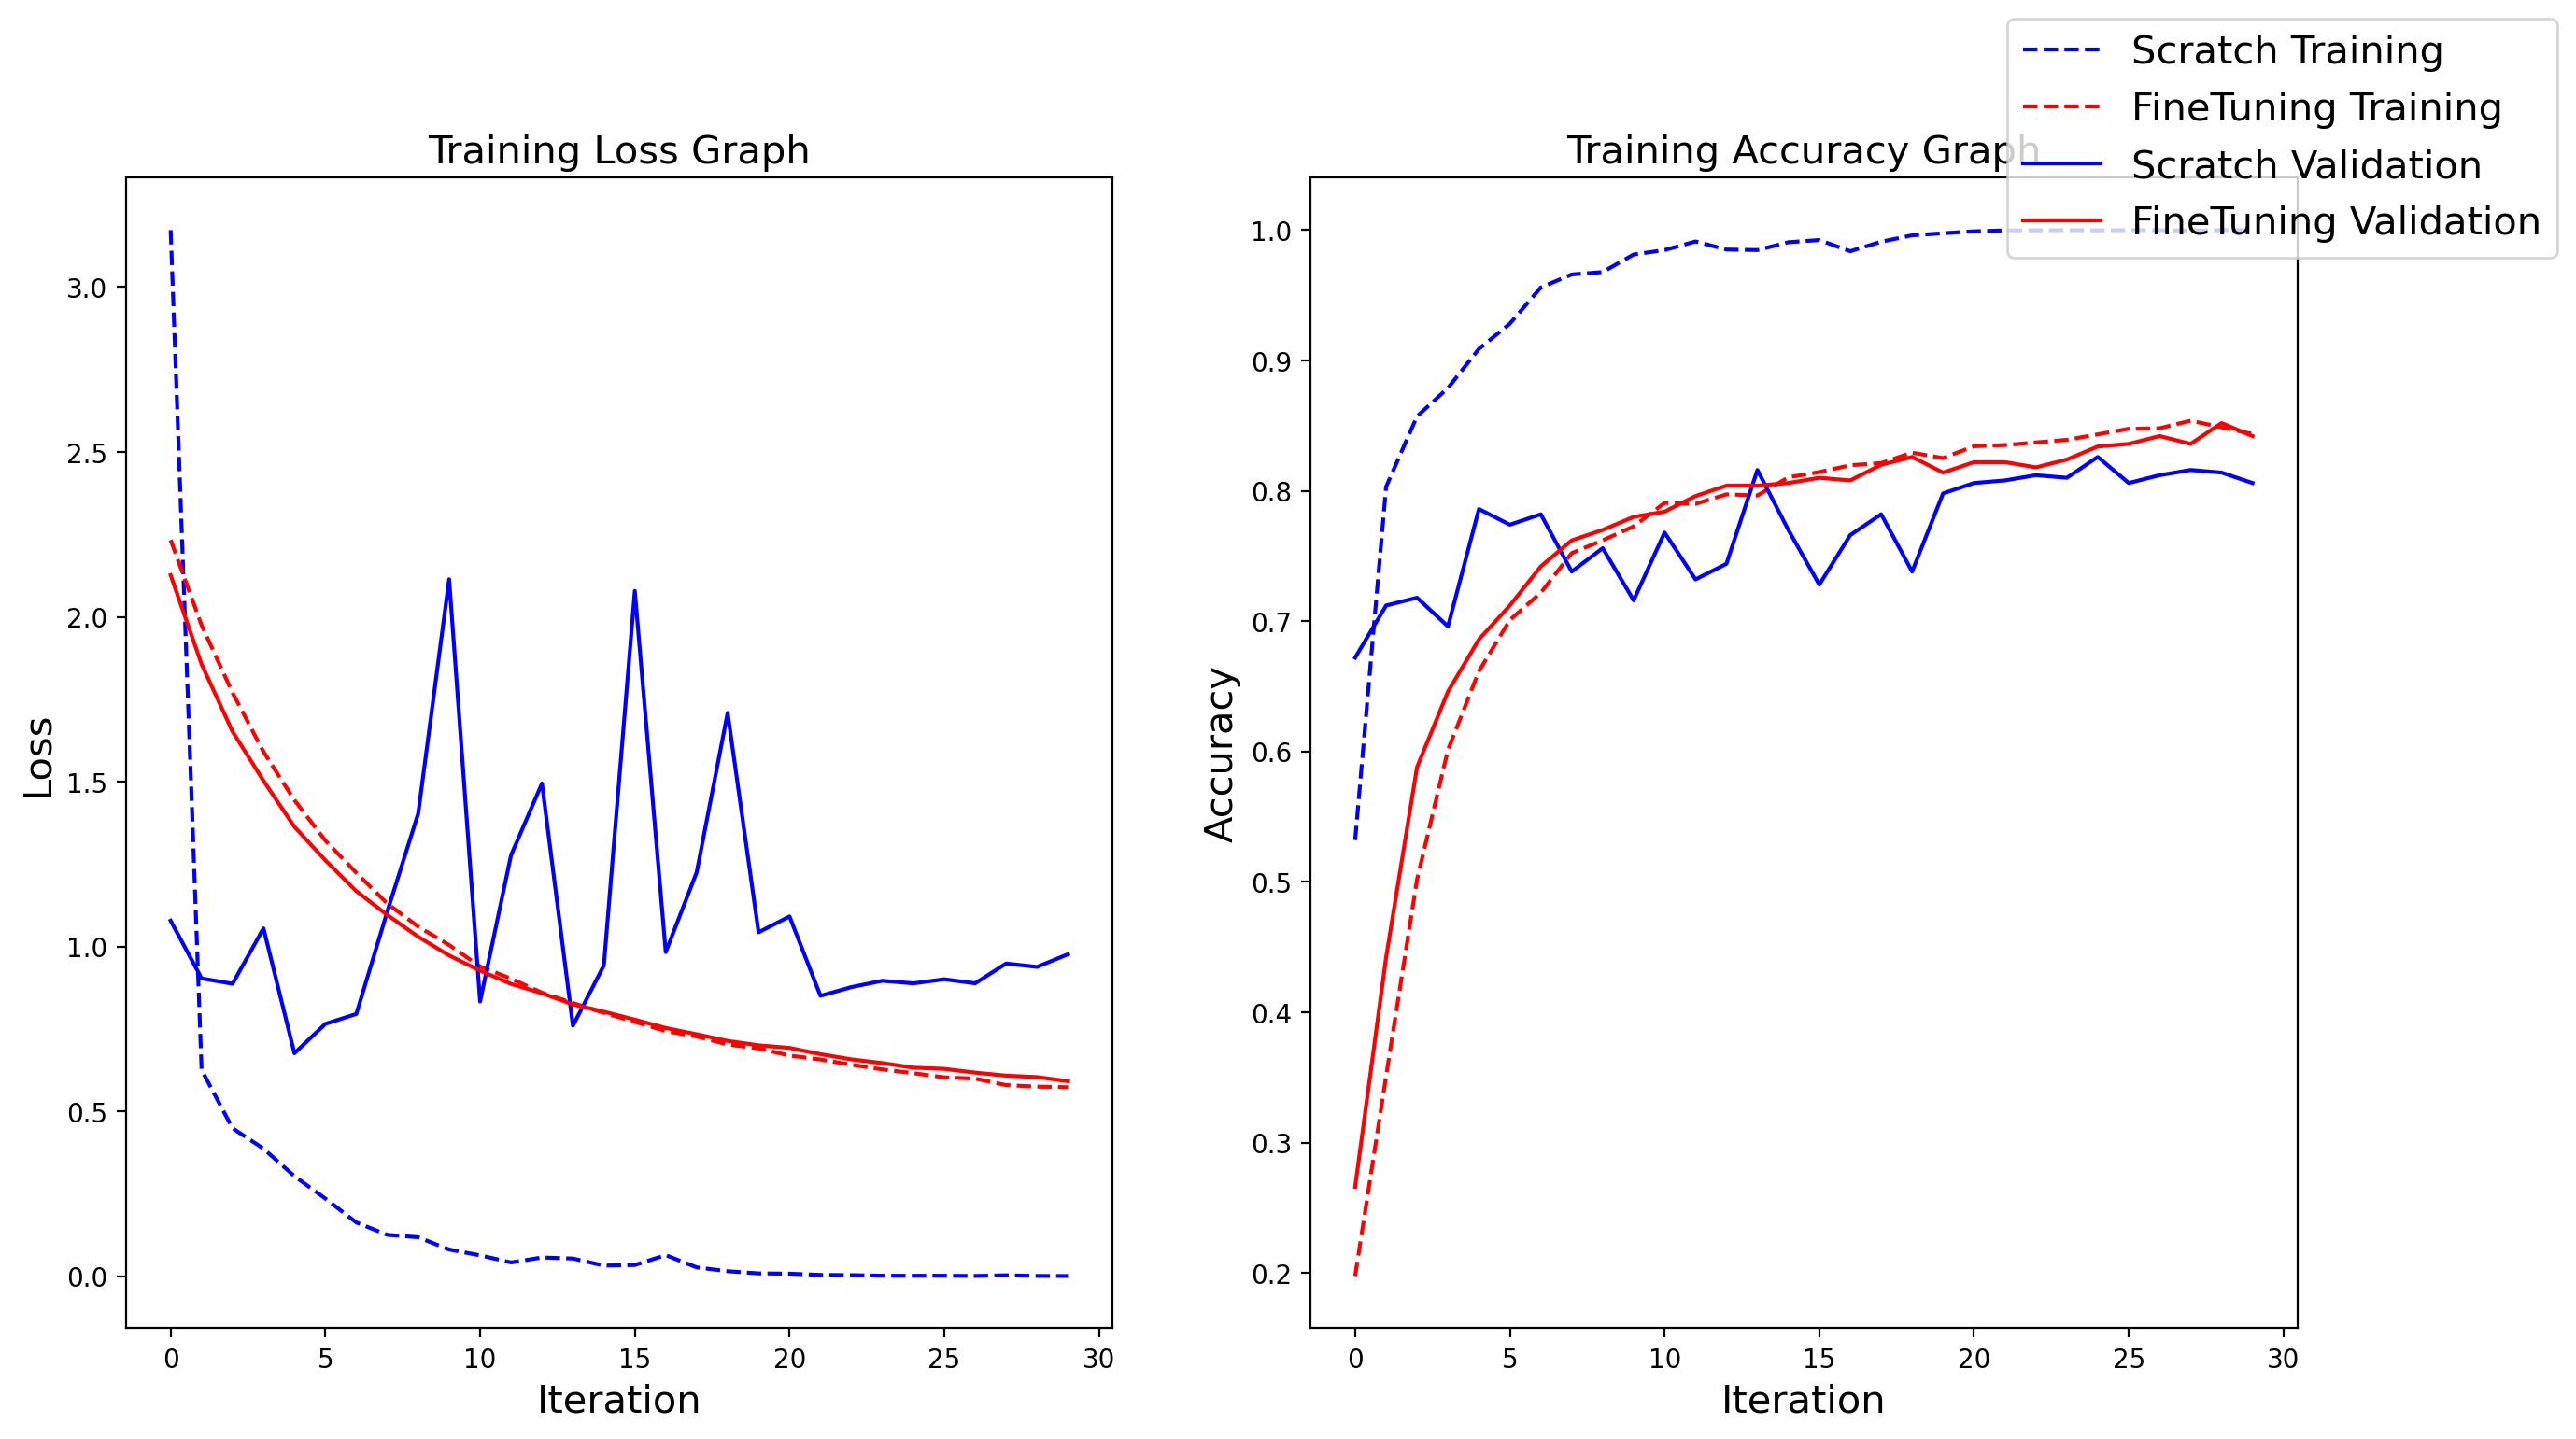

In [29]:
# Visualize the log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training', color='blue', linestyle='--')
ax1.plot(finetune_train_log.iloc[:,0], label='FineTuning Training', color='red', linestyle='--')
ax1.plot(scratch_train_log.iloc[:,2], label='Scratch Validation', color='blue', linestyle='-')
ax1.plot(finetune_train_log.iloc[:,2], label='FineTuning Validation', color='red', linestyle='-')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training', color='blue', linestyle='--')
ax2.plot(finetune_train_log.iloc[:,1], label='FineTuning Training', color='red', linestyle='--')
ax2.plot(scratch_train_log.iloc[:,3], label='Scratch Validation', color='blue', linestyle='-')
ax2.plot(finetune_train_log.iloc[:,3], label='FineTuning Validation', color='red', linestyle='-')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

### **7.2. Visualize some samples**

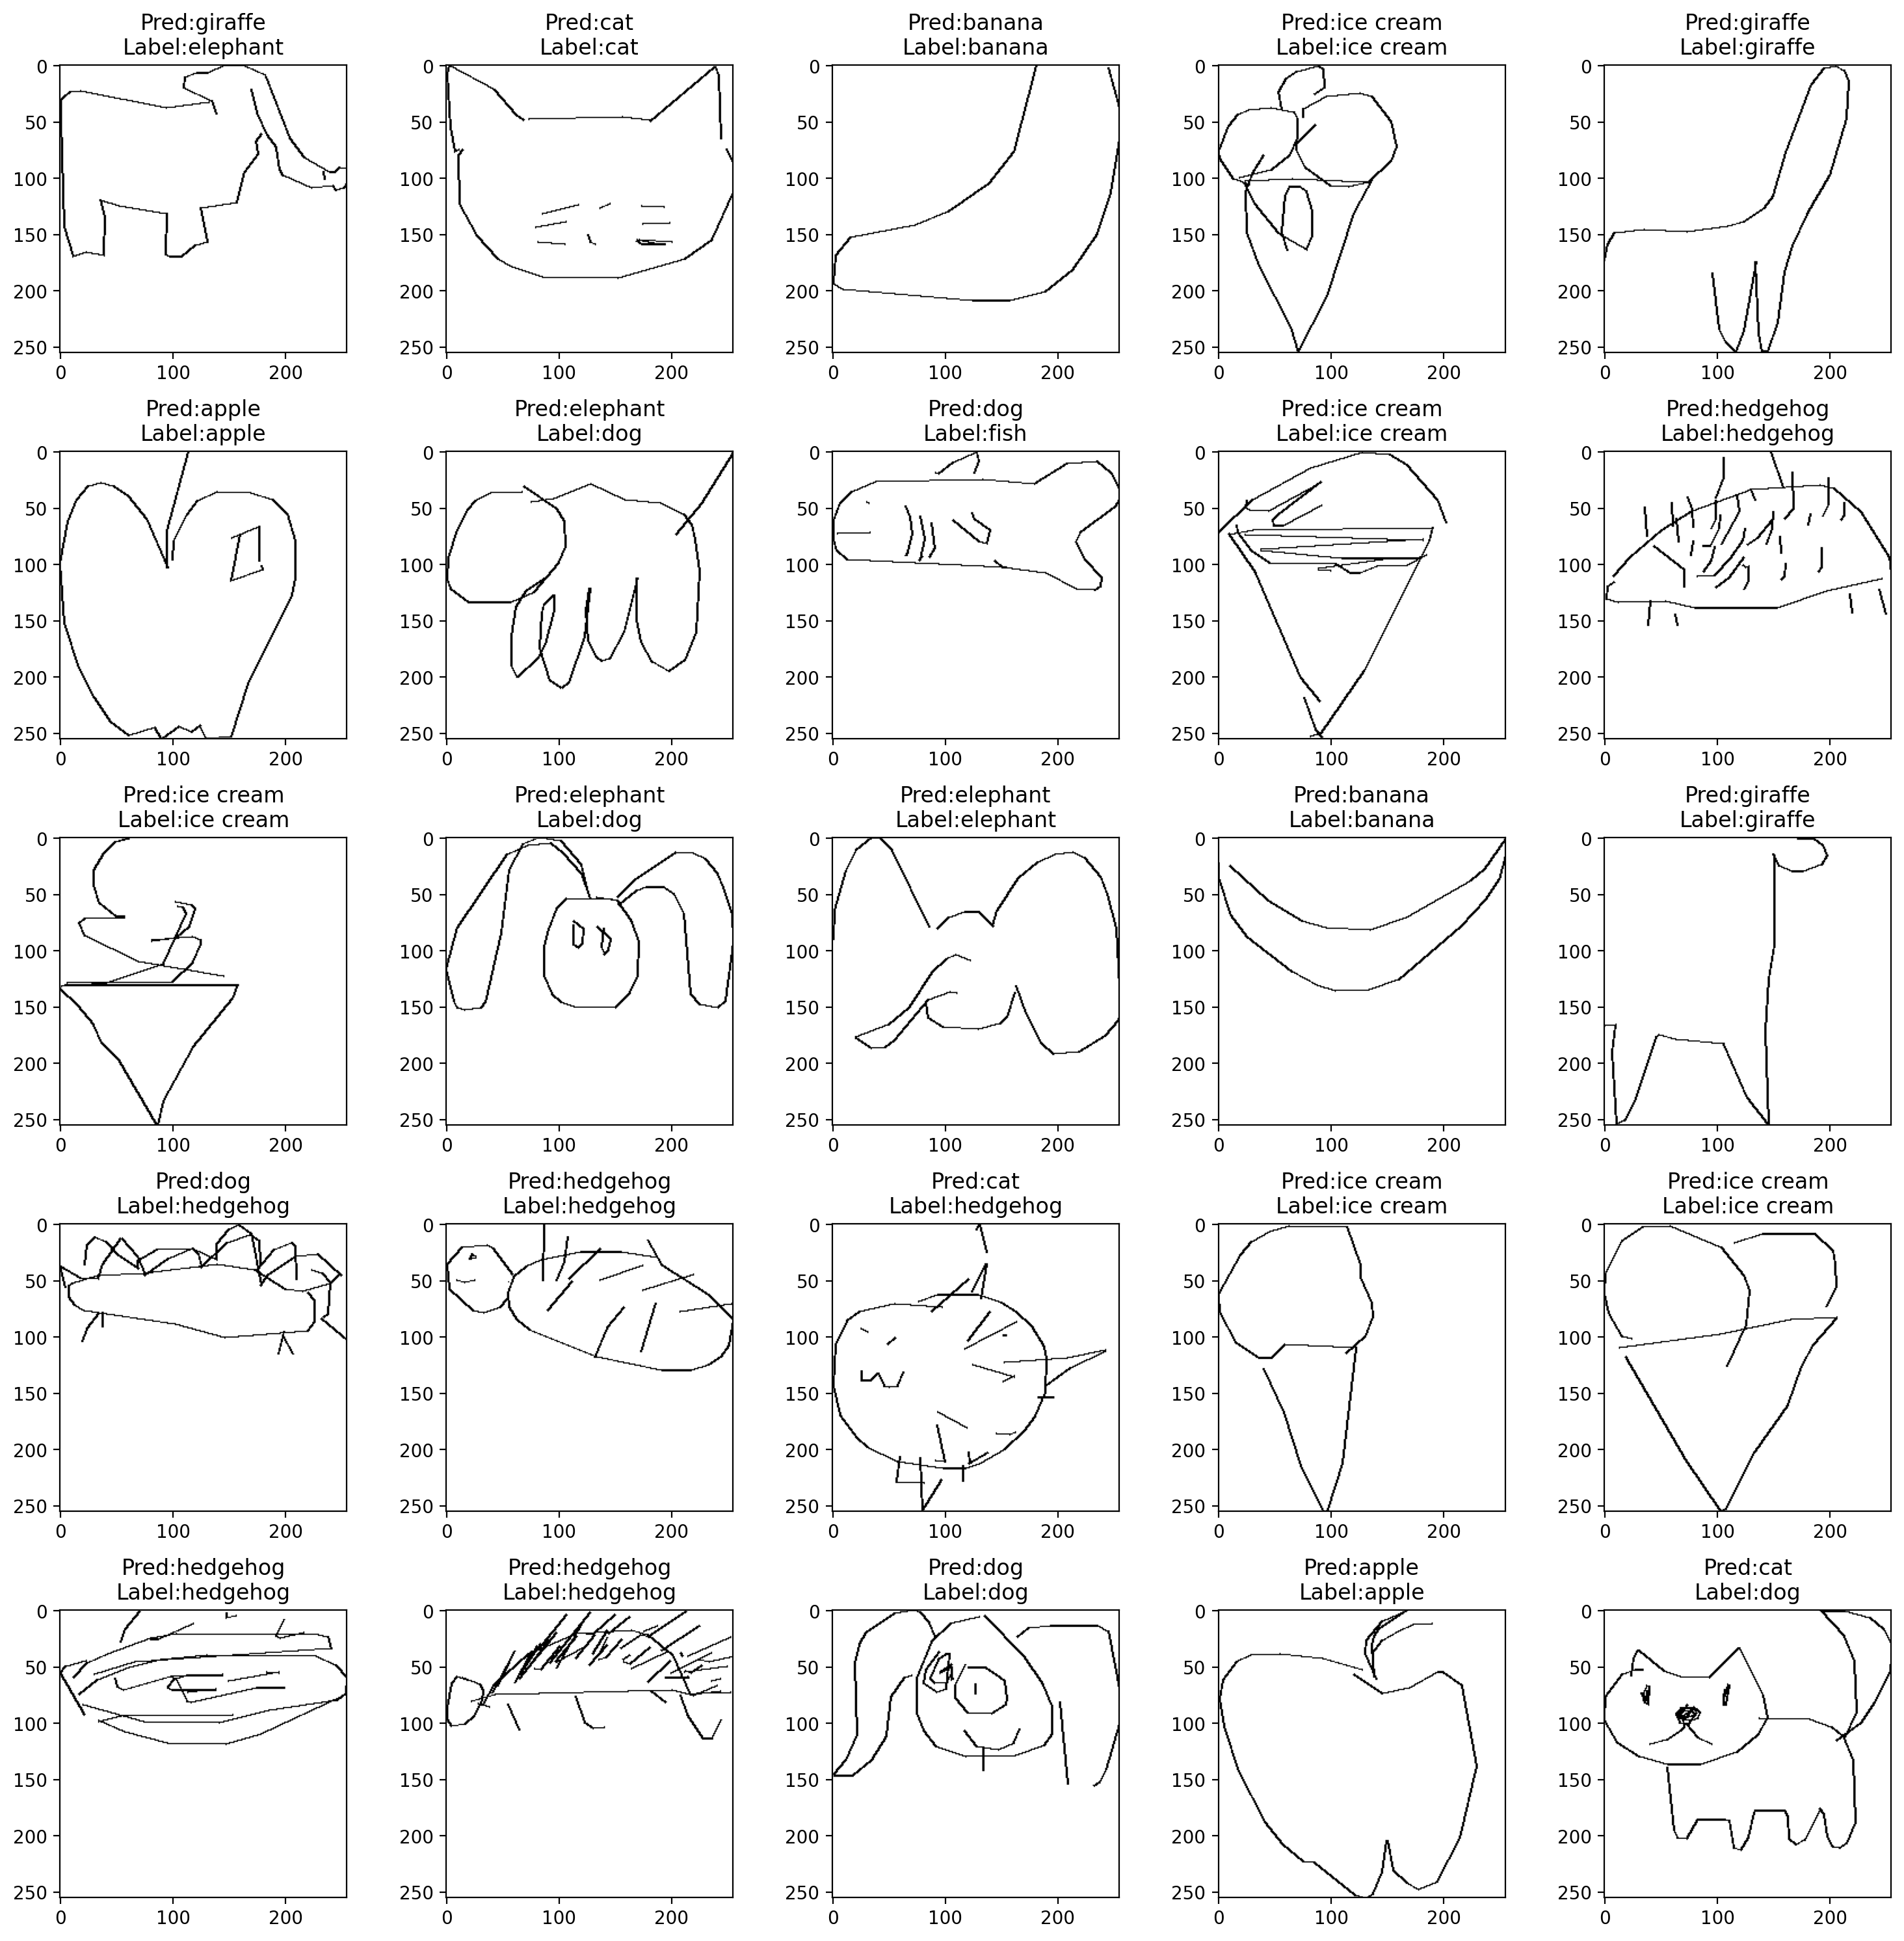

In [30]:
# no gradient calculation
with torch.no_grad():
    n_sample = 25  # number of samples
    # Get random n_sample images from the val set
    sample_indices = np.random.choice(len(qd_val_dataset.data), n_sample, replace=False)
    val_x = [transform(img) for img in np.asarray(qd_val_dataset.data)[sample_indices]]
    val_y = np.asarray(qd_val_dataset.labels)[sample_indices]
    # Move to the given device (cpu or gpu)
    val_x = torch.stack(val_x).to(device)
    
    # Compute the output
    y_pred = model_finetune(val_x)
    y_pred = y_pred.argmax(axis=1)
    
    # Plot the samples
    # Create a figure with size 15*15 inches
    plt.figure(figsize=(15,15))
    for idx in range(n_sample):
        # Create a subplot with 5 rows and 5 columns
        plt.subplot(5, 5, idx+1)
        # Plot the image
        plt.imshow(qd_val_dataset.data[sample_indices[idx]])
        # Set the title of the subplot using the predicted label
        plt.title("Pred:%s\nLabel:%s" % (class_list[y_pred[idx]], class_list[val_y[idx]]))
    # Show the plot
    plt.tight_layout()
    plt.show()

### **7.3. Visualize some incorrect samples**

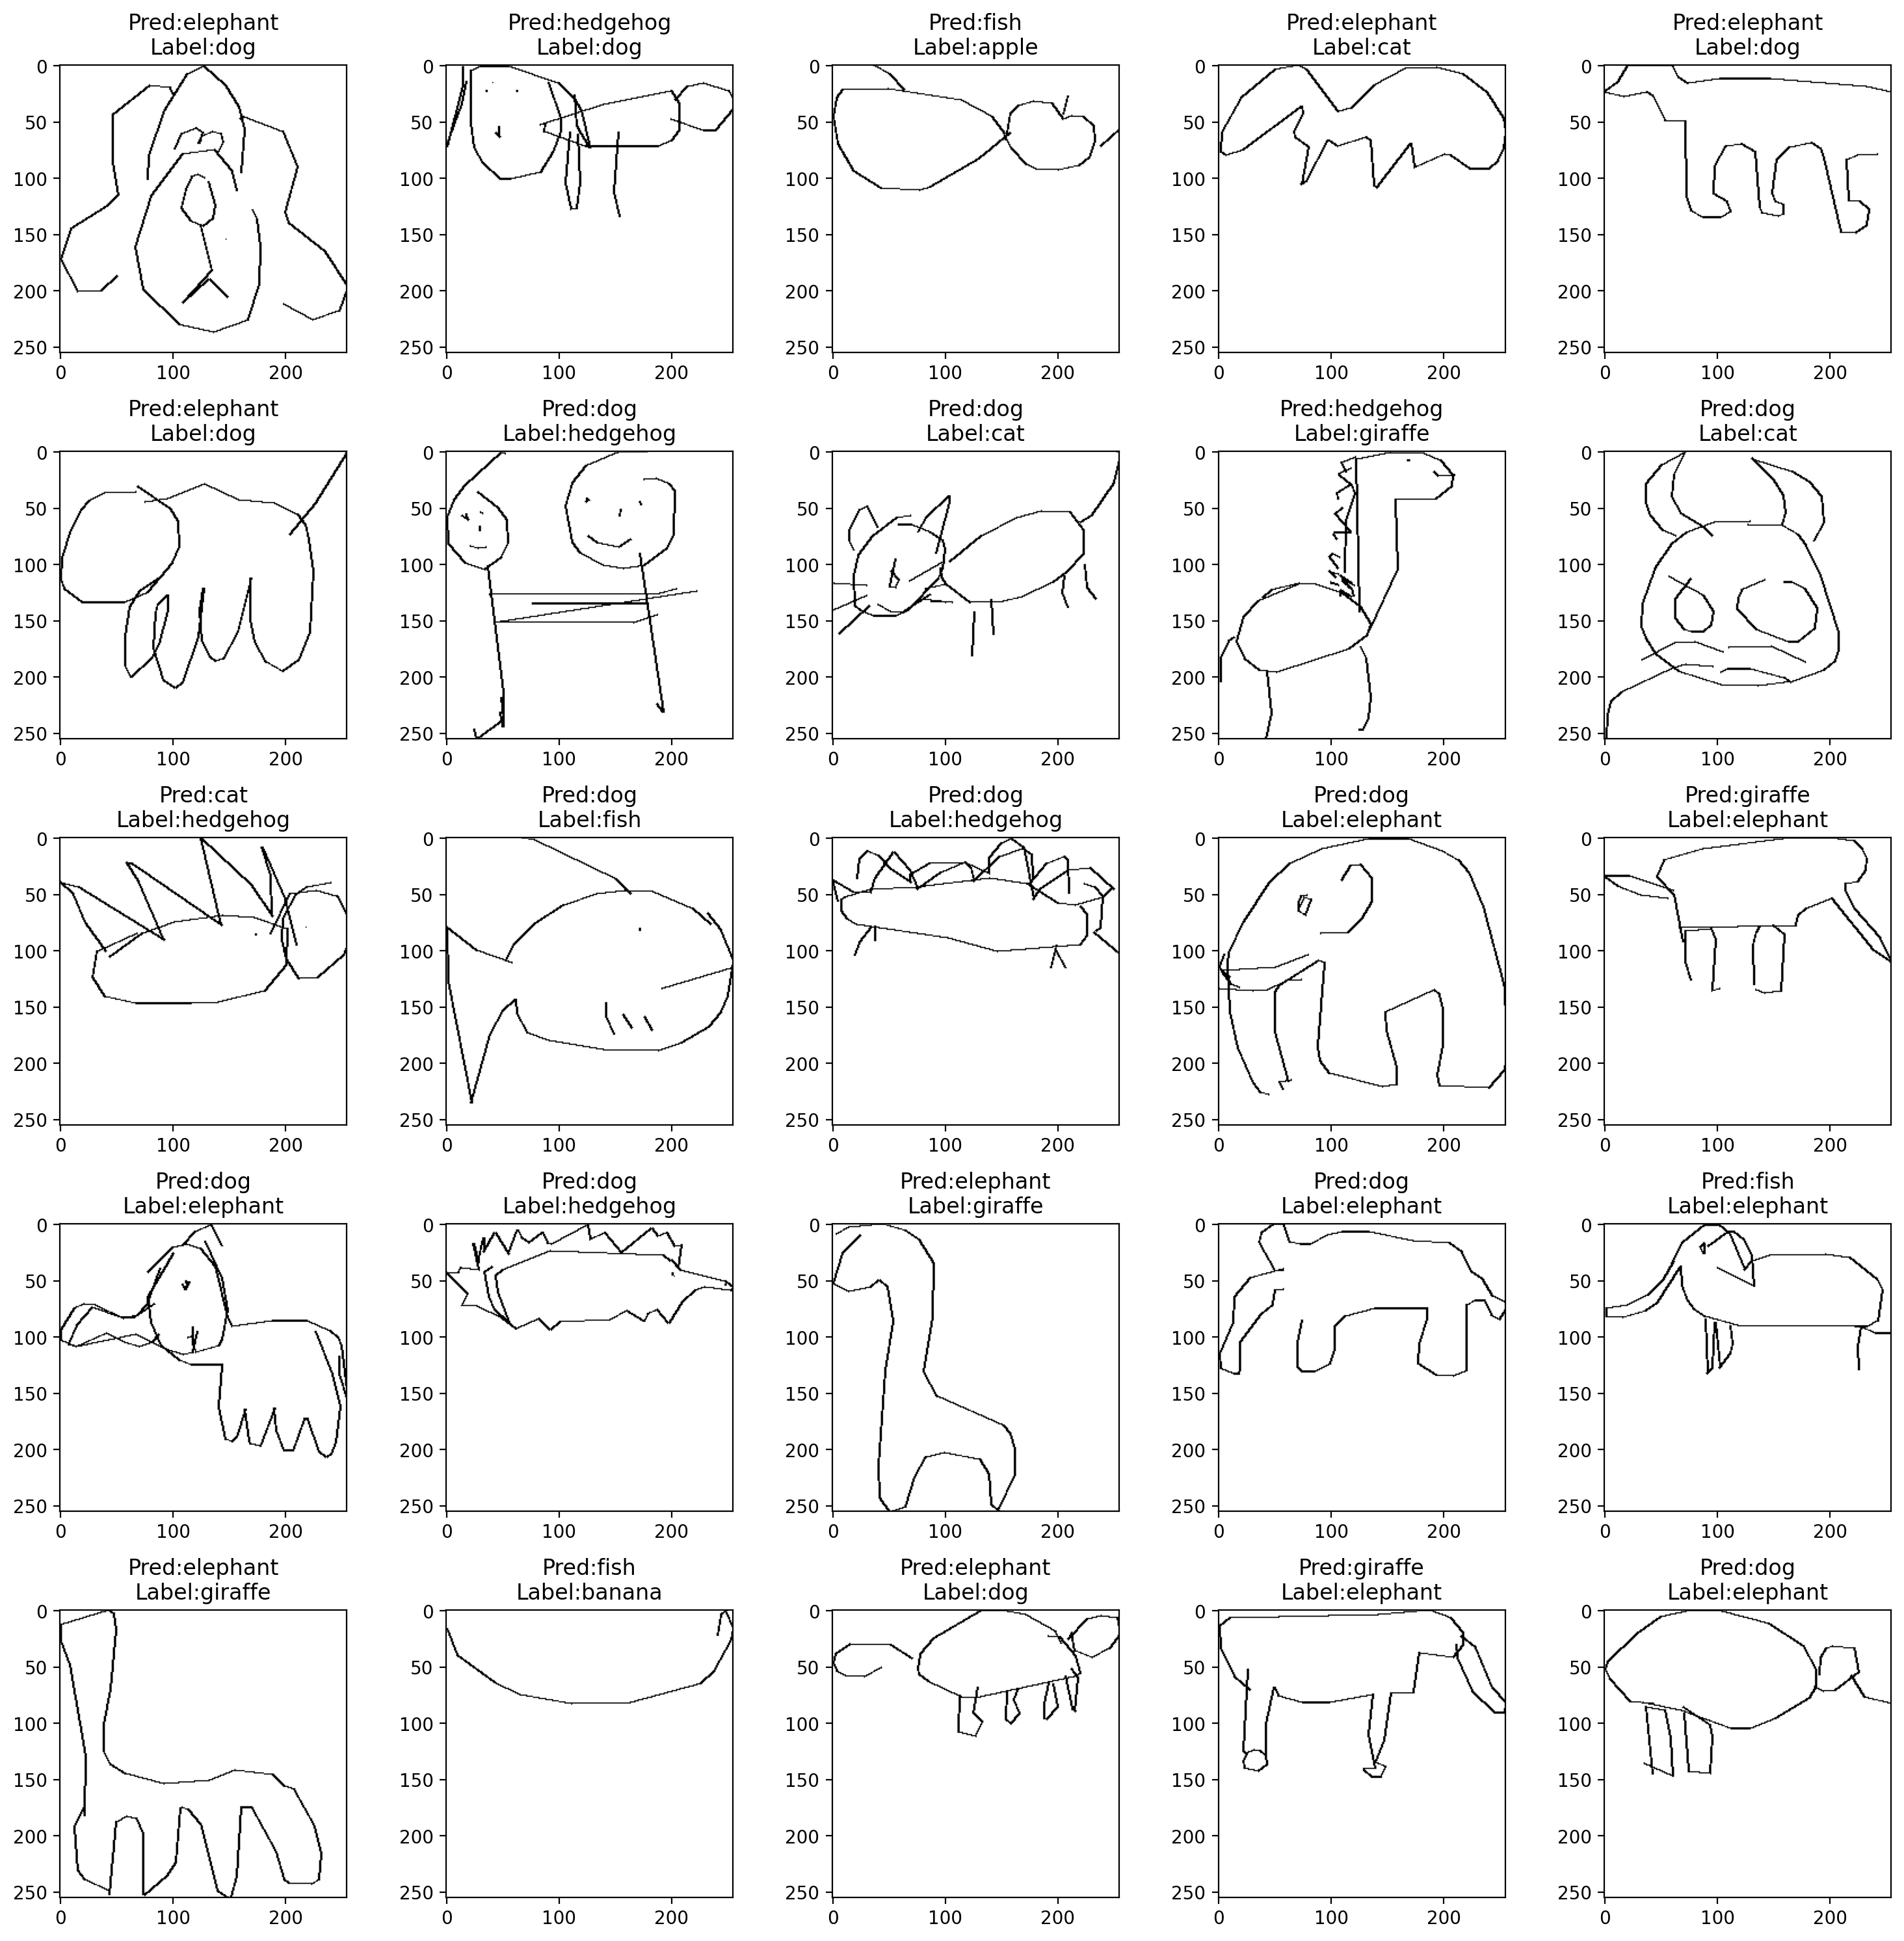

In [31]:
# no gradient calculation
with torch.no_grad():
    # Get entire validation dataset
    val_x = [transform(img) for img in np.asarray(qd_val_dataset.data)]
    val_y = np.asarray(qd_val_dataset.labels)
    # Move to the given device (cpu or gpu)
    val_x = torch.stack(val_x).to(device)
    
    # Compute the output
    y_pred = model_finetune(val_x)
    y_pred = y_pred.argmax(axis=1)

    # Get the indices of the incorrectly predicted samples
    # NOTE: (y_pred - val_y) != 0 means that the prediction is incorrect
    incorrect_indices = np.where((y_pred.cpu() - val_y) != 0)[0]

    # Get incorrect n_sample images from the val set
    n_sample = 25  # number of samples
    sample_indices = np.random.choice(incorrect_indices, n_sample, replace=False)
    
    # Plot the samples
    # Create a figure with size 15*15 inches
    plt.figure(figsize=(15,15))
    for idx in range(n_sample):
        # Create a subplot with 5 rows and 5 columns
        plt.subplot(5, 5, idx+1)
        # Plot the image
        plt.imshow(qd_val_dataset.data[sample_indices[idx]])
        # Set the title of the subplot using the predicted label
        plt.title("Pred:%s\nLabel:%s" % (class_list[y_pred[sample_indices[idx]]], 
                                         class_list[val_y[sample_indices[idx]]]))
    # Show the plot
    plt.tight_layout()
    plt.show()